1. Edge Index = 
 tensor([[0, 1],
        [2, 0],
        [2, 1],
        [1, 2]])
2. Edge weight = tensor([1, 1, 1, 1], dtype=torch.int32)
3. Test Edges = 
 tensor([[0, 1],
        [1, 2]])
4. Adjacency Matrix = 
 [[0 1 0]
 [0 0 1]
 [1 1 0]]
5. Negative Test Edges =
 tensor([[0, 2],
        [1, 0]])


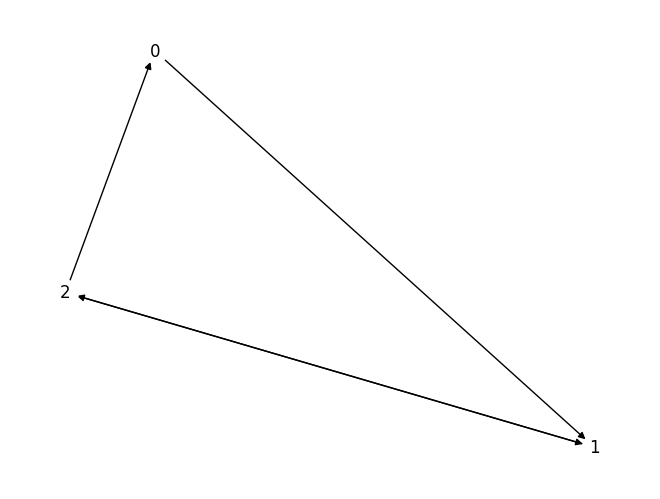

In [1]:
"""
testing the simple heuristics Personalized PageRank (PPR), Adamic Adar (AA) and Common Neighbours (CN)

This is the directed test graph
   -> 0 -> 1 <-
   |          |
    --- 2 <---
"""
import unittest
import math
import torch
from torch import tensor
import scipy.sparse as ssp
import numpy as np

edge_index = tensor([[0, 2, 2, 1], [1, 0, 1, 2]]).t()
edge_weight = torch.ones(edge_index.size(0), dtype=torch.int)
test_edges = tensor([[0, 1], [1, 2]]).t()
num_nodes = 3
A = ssp.csr_matrix((edge_weight, (edge_index[:, 0], edge_index[:, 1])),
                        shape=(num_nodes, num_nodes))#, dtype=np.float)
neg_test_edges = tensor([[0, 1], [2, 0]]).t()
print('1. Edge Index = \n %s' % edge_index, '2. Edge weight = %s' % edge_weight, sep='\n')
print('3. Test Edges = \n %s' % test_edges, '4. Adjacency Matrix = \n %s' % A.toarray(), sep='\n')
print('5. Negative Test Edges =\n %s' % neg_test_edges)

import networkx as nx
G = nx.DiGraph()
G.add_edges_from(edge_index.numpy())
nx.draw(G, with_labels=True, node_color='white')

In [2]:
"""
A selection of heuristic methods (Personalized PageRank, Adamic Adar and Common Neighbours) for link prediction
"""
import numpy as np
from tqdm import tqdm
import torch
from torch_geometric.loader import DataLoader

In [3]:
def CN(A, edge_index, batch_size=100000):
    """
    Common neighbours
    :param A: scipy sparse adjacency matrix
    :param edge_index: pyg edge_index
    :param batch_size: int
    :return: FloatTensor [edges] of scores, pyg edge_index
    """
    link_loader = DataLoader(range(edge_index.size(0)), batch_size)
    scores = []
    for ind in tqdm(link_loader):
        src, dst = edge_index[ind, 0], edge_index[ind, 1]
        cur_scores = np.array(np.sum(A[src].multiply(A[dst]), 1)).flatten()
        scores.append(cur_scores)
    scores = np.concatenate(scores, 0)
    print(f'evaluated Common Neighbours for {len(scores)} edges')
    return torch.FloatTensor(scores), edge_index

- `nx.adamic_adar_index(G, ebunch=None)` : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.adamic_adar_index.html#networkx.algorithms.link_prediction.adamic_adar_index

In [7]:
## For undirected graph
und_G = nx.complete_graph(4)
preds = nx.adamic_adar_index(und_G, [(0,1), (1,2)])
for u, v, p in preds:
    print(f"({u}, {v}) -> {p:.8f}")

(0, 1) -> 1.82047845
(1, 2) -> 1.82047845


In [4]:
mult = 1 / A.sum(axis=0) ## 행벡터로 보고 componentwise 하게 더하기
mult[np.isinf(mult)] = 0  ## nan or infinity 아닐 때 true 반환
A_ = A.multiply(mult)#.tocsr()
print(mult, A_.toarray(), sep='\n')

[[1.  0.5 1. ]]
[[0.  0.5 0. ]
 [0.  0.  1. ]
 [1.  0.5 0. ]]


In [6]:
def AA(A, edge_index, batch_size=100000):
    """
    Adamic Adar
    :param A: scipy sparse adjacency matrix
    :param edge_index: pyg edge_index
    :param batch_size: int
    :return: FloatTensor [edges] of scores, pyg edge_index
    """
    multiplier = 1 / np.log(A.sum(axis=0)) # 행벡터로 보고 componentwise 하게 더하기
    multiplier[np.isinf(multiplier)] = 0  ## nan or infinity 아닐 때 true 반환
    A_ = A.multiply(multiplier).tocsr()
    link_loader = DataLoader(range(edge_index.size(0)), batch_size)
    scores = []
    for ind in tqdm(link_loader):
        src, dst = edge_index[ind, 0], edge_index[ind, 1]
        cur_scores = np.array(np.sum(A[src].multiply(A_[dst]), 1)).flatten()
        scores.append(cur_scores)
    scores = np.concatenate(scores, 0)
    print(f'evaluated Adamic Adar for {len(scores)} edges')
    return torch.FloatTensor(scores), edge_index

In [ ]:
def RA(A, edge_index, batch_size=100000):
    """
    Resource Allocation https://arxiv.org/pdf/0901.0553.pdf
    :param A: scipy sparse adjacency matrix
    :param edge_index: pyg edge_index
    :param batch_size: int
    :return: FloatTensor [edges] of scores, pyg edge_index
    """
    multiplier = 1 / A.sum(axis=0)
    multiplier[np.isinf(multiplier)] = 0
    A_ = A.multiply(multiplier).tocsr()
    link_loader = DataLoader(range(edge_index.size(0)), batch_size)
    scores = []
    for ind in tqdm(link_loader):
        src, dst = edge_index[ind, 0], edge_index[ind, 1]
        cur_scores = np.array(np.sum(A[src].multiply(A_[dst]), 1)).flatten()
        scores.append(cur_scores)
    scores = np.concatenate(scores, 0)
    print(f'evaluated Resource Allocation for {len(scores)} edges')
    return torch.FloatTensor(scores), edge_index


In [ ]:
def PPR(A, edge_index):
    """
    The Personalized PageRank heuristic score.
    Need to install fast_pagerank by "pip install fast-pagerank"
    Too slow for large datasets now.
    :param A: A CSR matrix using the 'message passing' edges
    :param edge_index: The supervision edges to be scored
    :return:
    """
    from fast_pagerank import pagerank_power
    num_nodes = A.shape[0]
    src_index, sort_indices = torch.sort(edge_index[:, 0])
    dst_index = edge_index[sort_indices, 1]
    edge_reindex = torch.stack([src_index, dst_index])
    scores = []
    visited = set([])
    j = 0
    for i in tqdm(range(edge_reindex.shape[1])):
        if i < j:
            continue
        src = edge_reindex[0, i]
        personalize = np.zeros(num_nodes)
        personalize[src] = 1
        # get the ppr for the current source node
        ppr = pagerank_power(A, p=0.85, personalize=personalize, tol=1e-7)
        j = i
        # get ppr for all links that start at this source to save recalculating the ppr score
        while edge_reindex[0, j] == src:
            j += 1
            if j == edge_reindex.shape[1]:
                break
        all_dst = edge_reindex[1, i:j]
        cur_scores = ppr[all_dst]
        if cur_scores.ndim == 0:
            cur_scores = np.expand_dims(cur_scores, 0)
        scores.append(np.array(cur_scores))

    scores = np.concatenate(scores, 0)
    print(f'evaluated PPR for {len(scores)} edges')
    return torch.FloatTensor(scores), edge_reindex